# Detecção de pessoas utilizando HOG

Detectaremos pessoas em uma imagem utilizando o descritor HOG e o classificador SVM da biblioteca OpenCV

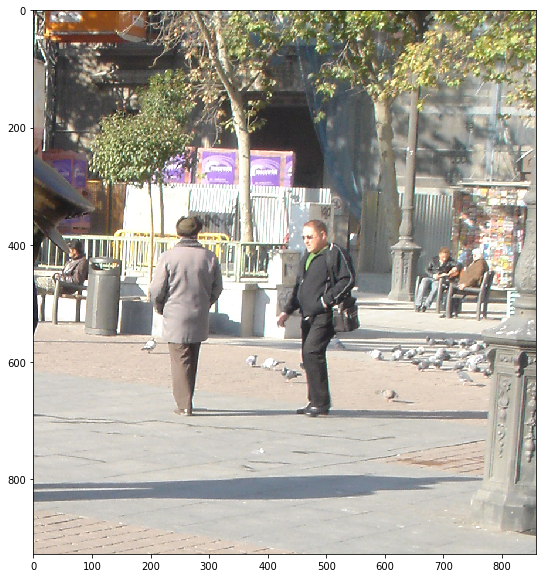

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('pessoas.png')
plt.figure(figsize=[10,10])
# O OpenCV sempre lê a imagem ordenando os canais no 
# padrão BGR (ao invés de RGB). Portanto, precisamos
# inverter os canais da imagem no momento da visualização
plt.imshow(img[:,:,::-1])

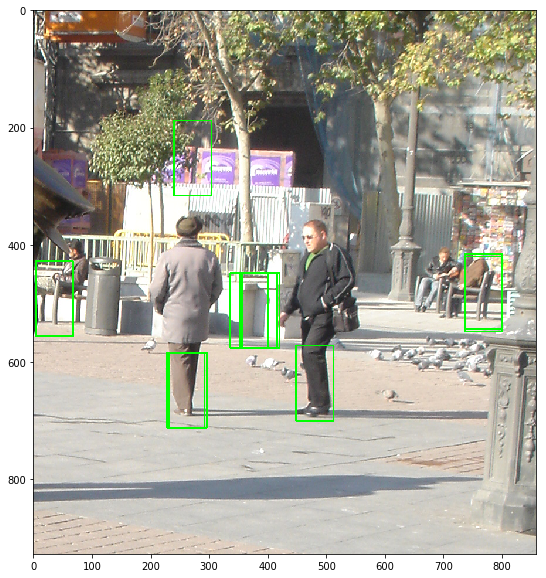

In [2]:
# Inicialização do descritor HOG, os parâmetros default
# da criação da instância da classe são:
# winSize = (64,128)      # Tamanho da imagem (tamanho da janela deslizante)
# blockSize = (16,16)     # Tamanho do bloco (quadrado azul nos slides)
# blockStride = (8,8)     # Quantos pixels o bloco é transladado para criar cada histograma
# cellSize = (8,8)        # Tamanho da célula
# nbins = 9               # Número de caixas no histograma
# hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
hog = cv2.HOGDescriptor()

# O OpenCV possui um classificador SVM pré-treinado em imagens de pessoas.
# Note que os parâmetros do HOG precisam ser iguais aos utilizados no treinamento,
# (parâmetros default descritos acima). Ou seja, vemos que o classificador foi
# treinado em imagens de tamanho 128x64 pixels
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Aplica a classificação na imagem. winstride ajusta o "passo" da janela,
# ou seja, o quanto ela é transladada em cada tentativa de classificação.
# A função retorna duas variáveis:
# window_pos: uma lista contendo a coordenada do canto superior esquerdo 
#        das janelas nas quais uma pessoa foi detectada. Cada elemento
#        da lista é uma tupla (x_ul, y_ul) contendo a coluna e a linha
#        do canto da janela
# weights: relacionado com a probabilidade de que a imagem contida em 
#          cada janela retornada é de fato de uma pessoa. weights possui 
#          dimensão len(window_pos)x1
window_pos, weights = hog.detect(img, winStride=(4, 4))
weights = weights[:,0]

# window_pos possui o canto superior esquerdo de retângulos que foram
# classificados como pessoas. É útil gerarmos uma nova lista possuindo
# os 4 cantos dos retângulos

boxes = np.zeros((len(window_pos), 4), dtype=int)
for window_index, (x, y) in enumerate(window_pos):
    boxes[window_index] = [x, y, x + 64, y + 128]

# Desenha os retângulos na imagem
img_result = img.copy()
for (xA, yA, xB, yB) in boxes:
    cv2.rectangle(img_result, (xA, yA), (xB, yB), (0, 255, 0), 2)

plt.figure(figsize=[10,10])
plt.imshow(img_result[:,:,::-1])

Vemos que a classificação retornada foi bem ruim. Dois problemas ocorreram: 1. A janela utilizada é em alguns casos menor e em outros casos maior do que as pessoas contidas na imagem. 2. Alguns casos possuem diversas janelas sobrepostas.

Vamos primeiro corrigir o problema 2

### Supressão de não-máximos

In [3]:
def non_max_suppression(boxes, weights, overlap_threshold=0.3):
    '''Elimina caixas possuindo alta intersecção. Quando duas ou mais caixas
       possuem intersecção maior que overlap_threshold, a caixa possuindo maior
       valor de weights é mantida. Um maior valor de weights indica uma maior 
       chance da caixa conter a imagem de uma pessoa.'''
    
    # Calcula área de cada caixa
    num_boxes = len(boxes)
    box_areas = np.zeros(num_boxes)
    for box_index, box in enumerate(boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]    
        box_areas[box_index] = (x2 - x1)*(y2 - y1)

    # Ordena as caixas e as áreas em ordem decrescente do respectivo
    # valor de weights. Isto é, boxes[0] e box_areas[0] passam a corresponder
    # à caixa possuindo maior chance de possuir uma pessoa.
    index_for_sorting = np.argsort(weights)[::-1]
    boxes = boxes[index_for_sorting]
    box_areas = box_areas[index_for_sorting]
    
    # Converte arrays numpy para listas, pois iremos remover elementos
    boxes = list(boxes)
    box_areas = list(box_areas)
    
    # Armazena caixas a serem mantidas
    picked_boxes = []
    while len(boxes) > 0:

        # Elimina primeira caixa da lista, e salva na lista final
        best_box = boxes.pop(0)
        area = box_areas.pop(0)
        picked_boxes.append(best_box)        
        
        # Calcula área de intersecção entre a caixa a ser mantida e
        # as demais caixas
        overlap_area = np.zeros(len(boxes))
        for box_index, box in enumerate(boxes):
           
            # Coordenadas do quadrado de intersecção entre as duas caixas
            x1_overlap = np.maximum(best_box[0], box[0])
            y1_overlap = np.maximum(best_box[1], box[1])
            x2_overlap = np.minimum(best_box[2], box[2])
            y2_overlap = np.minimum(best_box[3], box[3])

            # Se não houver intersecção, x2_overlap - x1_overlap será
            # menor que 0, o mesmo ocorre para a coordenada y
            width_overlap = np.maximum(0, x2_overlap - x1_overlap)
            height_overlap = np.maximum(0, y2_overlap - y1_overlap)

            overlap = (width_overlap*height_overlap)/area
            overlap_area[box_index] = overlap

        # Armazena índices das caixas a serem removidas
        boxes2rem = []
        for box_index, overlap in enumerate(overlap_area):
            if overlap > overlap_threshold:
                boxes2rem.append(box_index)
                
        # Elimina caixas
        for box_index in boxes2rem[::-1]:
            boxes.pop(box_index)
            box_areas.pop(box_index)

    picked_boxes = np.array(picked_boxes)
    
    return picked_boxes

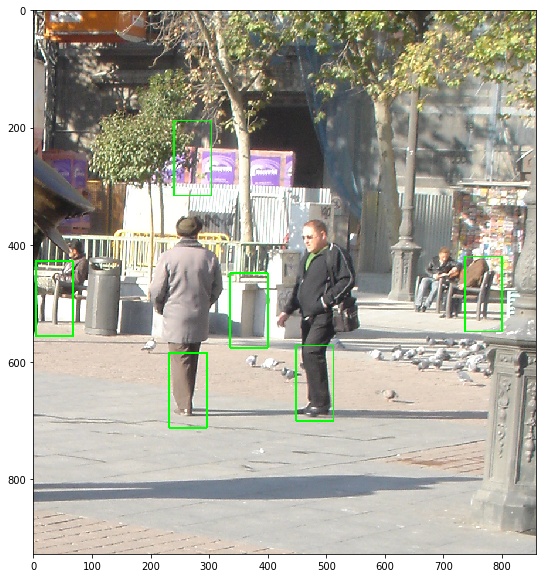

In [4]:
# Elimina regiões sobrepostas no resultado da classificação
picked_boxes = non_max_suppression(boxes, weights, overlap_threshold=0.3)

# Desenha os retângulos encontrados
img_result = img.copy()
for (xA, yA, xB, yB) in picked_boxes:
    cv2.rectangle(img_result, (xA, yA), (xB, yB), (0, 255, 0), 2)

plt.figure(figsize=[10,10]) 
plt.imshow(img_result[:,:,::-1])

### Detecção em múltiplas escalas

Vamos agora resolver o primeiro problema mencionado. Iremos tentar detectar pessoas em diversas escalas. Isso é feito construindo uma pirâmide da imagem e aplicando o descritor HOG e classificador SVM em cada nível da pirâmide. Utilizaremos uma função do OpenCV para aplicar o procedimento.

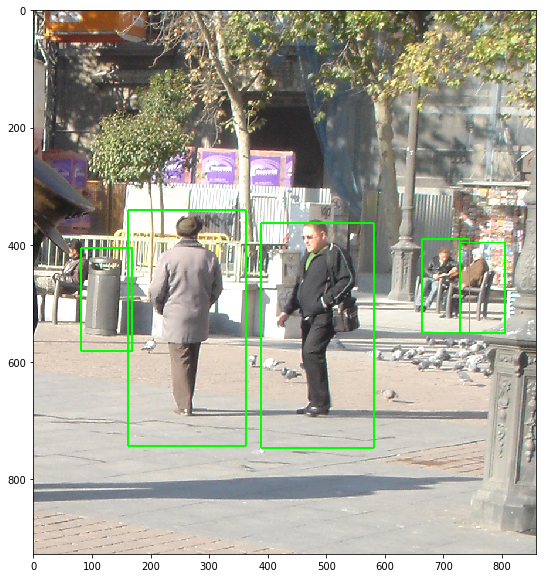

In [5]:
# O parâmetro scale ajusta a variação de escala entre níveis adjacentes da pirâmide
# O parâmetro finalThreshold é um limiar utilizado para selecionar apenas janelas
# possuindo maior probabilidade de conter pessoas. Em contraste com a função hog.detect(),
# a função hog.detectMultiScale() retorna em window_pos, além da posição do canto superior 
# esquerdo da janela, a largura e altura da janela encontrada.
window_pos, weights = hog.detectMultiScale(img, winStride=(4, 4), 
                                           scale=1.05, finalThreshold=10)
weights = weights[:,0]

# Cria retângulos e elimina retângulos sobrepostos
boxes = np.zeros((len(window_pos), 4), dtype=int)
for window_index, (x, y, w, h) in enumerate(window_pos):
    boxes[window_index] = [x, y, x+w, y+h]
    
picked_boxes = non_max_suppression(boxes, weights, overlap_threshold=0.3)

# Desenha retângulos finais
img_result = img.copy()
for (xA, yA, xB, yB) in picked_boxes:
    cv2.rectangle(img_result, (xA, yA), (xB, yB), (0, 255, 0), 2)

plt.figure(figsize=[10,10]) 
plt.imshow(img_result[:,:,::-1])

Note que a lixeira foi reconhecida como pessoa. Uma forma de melhorarmos o resultado é adicionarmos a imagem da lixeira na base de imagens, na classe de imagens negativas (não contendo pessoas).